<a href="https://colab.research.google.com/github/Priya-gawhane/CODSOFT/blob/main/Spam_SMS_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the dependencies

In [6]:
import re
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
np.random.seed(20)

data collection and preprocessing

In [7]:
spam_df = pd.read_csv("/content/spam.csv", encoding='latin-1', usecols=['v1', 'v2'])
spam_df.columns = ["label", "text"]
spam_df.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
def plot_confusion_matrix(model, X, y, ax, **kwargs):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    cm = confusion_matrix(y, pred)
    cm_norm = cm / cm.sum(1).reshape((-1, 1))
    labels = [f"{v}\n({pct:.2%})" for v, pct in zip(cm.flatten(), cm_norm.flatten())]
    labels = np.array(labels).reshape(cm.shape)

    sns.heatmap(cm, annot=labels, fmt="",
                ax=ax, yticklabels=le.classes_,
                xticklabels=le.classes_, cbar=False,
               cmap=["#1f1e1a", "#b09302"])
    ax.set_title(f"{kwargs.get('name').upper()} - {acc:.2%}", size=10.5, alpha=0.65)


def build_model_pipeline(model, name):
    pipeline = Pipeline(steps=[
        ("tfidf", TfidfVectorizer(min_df=2, stop_words=list(ENGLISH_STOP_WORDS))),
        (name, model)
    ])
    return pipeline


def plot_roc(model, X, y, ax, **kwargs):
    pred_prob = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, pred_prob)
    fpr, tpr, threshold = roc_curve(y, pred_prob)

    ax.plot(fpr, tpr, label=f'{kwargs.get("name")} - AUC = {auc:.2%}')
    straight_line = np.linspace(0, 1, len(fpr))
    ax.plot(straight_line, straight_line)
    ax.fill_between(fpr, fpr, tpr, alpha=0.1)
    ax.legend(loc=4, frameon=True, edgecolor="gray")
    ax.set_title("ROC Curve", size=11)
    ax.grid(visible=False, axis="y")
    ax.set(ylabel="tpr", xlabel="fpr")


def evaluate_model(model, X, y, name):
    pred = model.predict(X)
    prf = precision_recall_fscore_support(y, pred)[:-1]
    metrics = "precision_recall_fscore".split("_")
    arrays = [["", name, ""], metrics]
    index = pd.MultiIndex.from_arrays(arrays, names=('model', 'metric'))
    df = pd.DataFrame(prf, columns=le.classes_, index=index)

    return df


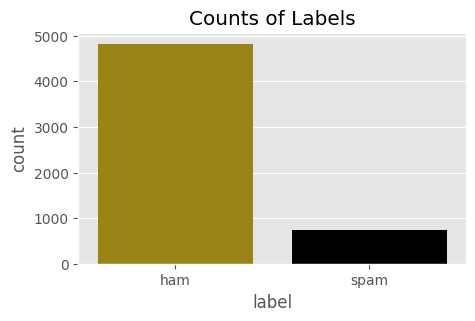

In [9]:
fig = plt.figure(figsize=(5, 3))
sns.countplot(data=spam_df, x='label', palette=["#b09302", "#000000"])
plt.title("Counts of Labels")
plt.show()

In [10]:
spam = spam_df[spam_df.label=='spam']
ham = spam_df[spam_df.label=='ham'].sample(spam.shape[0])

spam_df = pd.concat([spam, ham], axis=0)

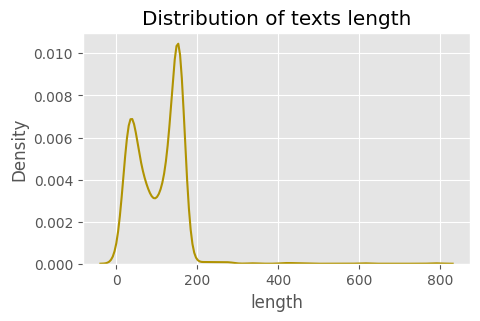

In [11]:
spam_df['length'] = spam_df.text.apply(len)

fig = plt.figure(figsize=(5, 3))
sns.kdeplot(data=spam_df, x='length', color = '#b09302')
plt.title("Distribution of texts length")
plt.show()

In [12]:
def process_text(message):
    text_split = message.lower().split()
    texts = [word for word in text_split if word not in string.punctuation]
    texts = [re.sub("[^a-zA-Z]", " ", word).strip() for word in texts]
    texts = " ".join(texts)
    texts = [word for word in texts.split() if word not in ENGLISH_STOP_WORDS and len(word)>1]

    return " ".join(texts)

In [13]:
process_text("Todays Voda numbers ending 1225 are selected to receive a å£50award. \
            If you have a match please call 08712300220 quoting claim code 3100 standard rates app")

'todays voda numbers ending selected receive award match quoting claim code standard rates app'

In [14]:
spam_df['text'] = spam_df['text'].apply(process_text)

spam_df.sample(5)

,label,text,length
1463,ham,ok good later come lucky told earlier later pp...,114
2313,ham,guys,23
3290,ham,smoking people use wylie smokes justify ruinin...,85
2604,ham,times job today ok umma ask speed,57
4018,spam,ve selected stay british hotels holiday valued...,159


In [15]:
le = LabelEncoder()

spam_df.reset_index(drop=True, inplace=True)
x = spam_df.text
y = le.fit_transform(spam_df.label)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

building model pipeline

In [16]:
models = {
    "nb": build_model_pipeline(MultinomialNB(), "nb").fit(x_train, y_train),
    "knn": build_model_pipeline(KNeighborsClassifier(n_neighbors=70), "knn").fit(x_train, y_train),
    "lr": build_model_pipeline(LogisticRegression(solver="liblinear"), "lr").fit(x_train, y_train),
    "rfc": build_model_pipeline(RandomForestClassifier(max_depth=10), "rfc").fit(x_train, y_train)
}